# Library import

In [1]:
library(tidyverse)
library(lubridate)
library(highcharter)
library(plotly)
library(cluster)
library(factoextra)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Data import

In [2]:
df_data <- read.csv("data.csv")
glimpse(df_data)

Rows: 541,909
Columns: 8
$ InvoiceNo   <chr> "536365", "536365", "536365", "536365", "536365", "536365"~
$ StockCode   <chr> "85123A", "71053", "84406B", "84029G", "84029E", "22752", ~
$ Description <chr> "WHITE HANGING HEART T-LIGHT HOLDER", "WHITE METAL LANTERN~
$ Quantity    <int> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, 3, ~
$ InvoiceDate <chr> "12/1/2010 8:26", "12/1/2010 8:26", "12/1/2010 8:26", "12/~
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1.69~
$ CustomerID  <int> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17~
$ Country     <chr> "United Kingdom", "United Kingdom", "United Kingdom", "Uni~


## Data cleansing

In [3]:
df_data <- df_data %>% 
  mutate(Quantity = replace(Quantity, Quantity<=0, NA),
         UnitPrice = replace(UnitPrice, UnitPrice<=0, NA))
df_data <- df_data %>%
  drop_na()
glimpse(df_data)

Rows: 397,884
Columns: 8
$ InvoiceNo   <chr> "536365", "536365", "536365", "536365", "536365", "536365"~
$ StockCode   <chr> "85123A", "71053", "84406B", "84029G", "84029E", "22752", ~
$ Description <chr> "WHITE HANGING HEART T-LIGHT HOLDER", "WHITE METAL LANTERN~
$ Quantity    <int> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, 3, ~
$ InvoiceDate <chr> "12/1/2010 8:26", "12/1/2010 8:26", "12/1/2010 8:26", "12/~
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1.69~
$ CustomerID  <int> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17~
$ Country     <chr> "United Kingdom", "United Kingdom", "United Kingdom", "Uni~


# RFM Analysis

In [4]:
df_data <- df_data %>% 
  mutate(InvoiceNo=as.factor(InvoiceNo), StockCode=as.factor(StockCode), 
         InvoiceDate=as.Date(InvoiceDate, '%m/%d/%Y %H:%M'), CustomerID=as.factor(CustomerID), 
         Country=as.factor(Country))

df_data$total_dolar = df_data$Quantity * df_data$UnitPrice

df_data$days <- weekdays(df_data$InvoiceDate)
df_data$days <- as.factor(df_data$days)

df_data$mday <- mday(as.POSIXlt(df_data$InvoiceDate))

glimpse(df_data)

Rows: 397,884
Columns: 11
$ InvoiceNo   <fct> 536365, 536365, 536365, 536365, 536365, 536365, 536365, 53~
$ StockCode   <fct> 85123A, 71053, 84406B, 84029G, 84029E, 22752, 21730, 22633~
$ Description <chr> "WHITE HANGING HEART T-LIGHT HOLDER", "WHITE METAL LANTERN~
$ Quantity    <int> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, 3, ~
$ InvoiceDate <date> 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-0~
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1.69~
$ CustomerID  <fct> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17~
$ Country     <fct> United Kingdom, United Kingdom, United Kingdom, United Kin~
$ total_dolar <dbl> 15.30, 20.34, 22.00, 20.34, 20.34, 15.30, 25.50, 11.10, 11~
$ days        <fct> Wednesday, Wednesday, Wednesday, Wednesday, Wednesday, Wed~
$ mday        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1~


### Total customer per month

In [5]:
customer <- df_data %>%
  group_by(InvoiceDate) %>%
  summarise(total_customer = n_distinct(CustomerID))

customer$month <- floor_date(customer$InvoiceDate, "month")

customer <- customer %>%
  group_by(month) %>%
  summarize(total_customer = sum(total_customer)) %>%
  filter(month != "2011-12-01") 

hc <- customer %>% hchart(
  'line', hcaes(x = month, y = total_customer),
  color = "steelblue"
  ) %>% 
  hc_title(text="Total Customer per Month") 

hc


HTML widgets cannot be represented in plain text (need html)

### Total transaction per month

In [6]:
transaction <- df_data %>%
  group_by(InvoiceDate) %>%
  summarise(total_transaction = n_distinct(InvoiceNo))

transaction$month <- floor_date(transaction$InvoiceDate, "month")

transaction <- transaction %>%
  group_by(month) %>%
  summarize(total_transaction = sum(total_transaction)) %>%
  filter(month != "2011-12-01") 

ht <- transaction %>% hchart(
  'line', hcaes(x = month, y = total_transaction),
  color = "steelblue"
  ) %>% 
  hc_title(text="Total Transaction per Month") 

ht

HTML widgets cannot be represented in plain text (need html)

### Total sales per month

In [7]:
sales <- df_data %>%
  mutate(total_dolar) %>%
  group_by(InvoiceDate) %>%
  summarise(total_sales = sum(total_dolar))

sales$month <- floor_date(sales$InvoiceDate, "month")

sales <- sales %>%
  group_by(month) %>%
  summarize(total_sales = sum(total_sales)) %>%
  filter(month != "2011-12-01") 

hs <- sales %>% hchart(
  'line', hcaes(x = month, y = total_sales),
  color = "steelblue"
  ) %>% 
  hc_title(text="Total Sales per Month") 

hs

HTML widgets cannot be represented in plain text (need html)

### Classify new & returning customer

In [8]:
sales_data <- df_data %>%
  group_by(CustomerID)%>%
  mutate(date_of_first_engagement=min(InvoiceDate))%>% #customer first order
  ungroup()

sales_data <- sales_data%>%
  mutate(Customer_Status = case_when(InvoiceDate>date_of_first_engagement ~ "Returning",
                                     InvoiceDate == date_of_first_engagement ~ "New",
                                     TRUE ~ "Other"))

New_and_Returning_Customers <-  sales_data%>%
  group_by(floor_date(InvoiceDate,unit = 'month'))%>%
  summarise(New_Customers = n_distinct(CustomerID[Customer_Status=="New"]),
            Returning_Customers= n_distinct(CustomerID[Customer_Status=="Returning"]))

colnames(New_and_Returning_Customers) <- c("Date", "New_Cus", "Return_Cus")
New_and_Returning_Customers

Date       New_Cus Return_Cus
1  2010-12-01 885      212      
2  2011-01-01 417      358      
3  2011-02-01 380      403      
4  2011-03-01 452      542      
5  2011-04-01 300      581      
6  2011-05-01 284      791      
7  2011-06-01 242      766      
8  2011-07-01 188      774      
9  2011-08-01 169      774      
10 2011-09-01 299      989      
11 2011-10-01 358     1041      
12 2011-11-01 323     1378      
13 2011-12-01  41      574

### Determine mean sales by month

In [9]:
New_and_Returning_Customers %>% 
  filter(Date != "2011-12-01") %>% hchart(
  'line', hcaes(x = Date, y = New_Cus),
  color = "steelblue"
  ) %>% 
  hc_title(text="Mean Sales per Month of New Customers") 

HTML widgets cannot be represented in plain text (need html)

In [10]:
New_and_Returning_Customers %>% 
  filter(Date != "2011-12-01") %>% hchart(
  'line', hcaes(x = Date, y = Return_Cus),
  color = "steelblue"
  ) %>% 
  hc_title(text="Mean Sales per Month of Returning Customers") 

HTML widgets cannot be represented in plain text (need html)

The analysis shows that the sales are quite good for increasing by month, despite the decreasing new customers. Hence, the recommendation for the company is to increase the sales from returning customers.

## Create RFM data

In [11]:
df_RFM <- df_data %>% 
  group_by(CustomerID) %>% 
  summarise(recency=as.numeric(as.Date("2012-01-01")-max(InvoiceDate)),
            frequency=n_distinct(InvoiceNo),
            monitery= sum(total_dolar)/n_distinct(InvoiceNo))

summary(df_RFM)

   CustomerID      recency        frequency          monitery       
 12346  :   1   Min.   : 23.0   Min.   :  1.000   Min.   :    3.45  
 12347  :   1   1st Qu.: 40.0   1st Qu.:  1.000   1st Qu.:  178.62  
 12348  :   1   Median : 73.0   Median :  2.000   Median :  293.90  
 12349  :   1   Mean   :115.1   Mean   :  4.272   Mean   :  419.17  
 12350  :   1   3rd Qu.:164.8   3rd Qu.:  5.000   3rd Qu.:  430.11  
 12352  :   1   Max.   :396.0   Max.   :209.000   Max.   :84236.25  
 (Other):4332                                                       

## Recency Segmentation

In [12]:
hchart(hist(
    df_RFM$recency, breaks = 396, plot=FALSE), type = 'histogram', name = 'Recency Counts',
       color = '#669900') %>% 
  hc_title(text="Recency Segmentation") 

HTML widgets cannot be represented in plain text (need html)

In [13]:
df_RFM$frequency_standard <- scale(df_RFM$frequency)
summary(scale(df_RFM$frequency))

       V1          
 Min.   :-0.42505  
 1st Qu.:-0.42505  
 Median :-0.29514  
 Mean   : 0.00000  
 3rd Qu.: 0.09457  
 Max.   :26.59496  

In [14]:
df_RFM$monitery_standard <- scale(df_RFM$monitery)
summary(scale(df_RFM$monitery))

       V1          
 Min.   :-0.23140  
 1st Qu.:-0.13389  
 Median :-0.06973  
 Mean   : 0.00000  
 3rd Qu.: 0.00609  
 Max.   :46.65478  

### Determine optimal number of clusters

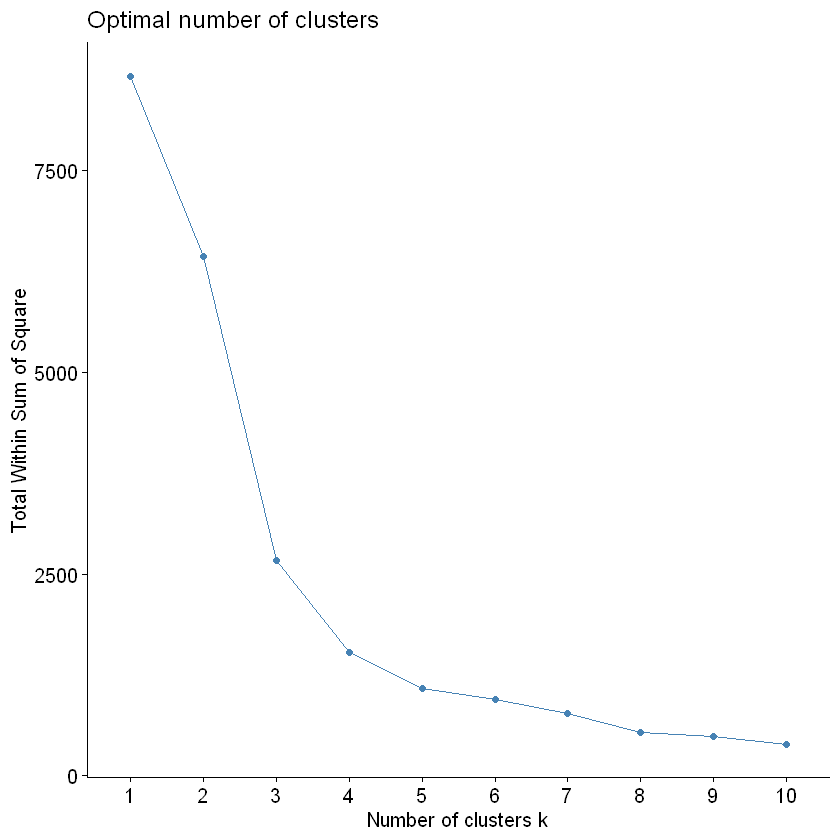

In [15]:
set.seed(1)
fviz_nbclust(df_RFM[c("frequency_standard", "monitery_standard")], kmeans, method = "wss")

4 is chosen for the optimal number of clusters derived from the plot above

In [16]:
segmentasi <- kmeans(x=df_RFM[c("frequency_standard", "monitery_standard")], 
                     centers=4, nstart=25)
summary(segmentasi$centers)

 frequency_standard monitery_standard 
 Min.   :-0.3601    Min.   :-0.02785  
 1st Qu.:-0.2281    1st Qu.: 0.03908  
 Median : 0.8426    Median : 0.14298  
 Mean   : 4.1465    Mean   :11.23751  
 3rd Qu.: 5.2173    3rd Qu.:11.34141  
 Max.   :15.2608    Max.   :44.69194  

In [17]:
df_RFM$cluster <- segmentasi$cluster

df_RFM %>%
  group_by(cluster) %>%
  summarise(mean_freq = mean(frequency),
            mean_monitery = mean(monitery))

cluster mean_freq  mean_monitery
1 1         2.854464   369.1292   
2 2        18.662614   529.4672   
3 3         1.500000 80709.9250   
4 4       121.750000   822.6206

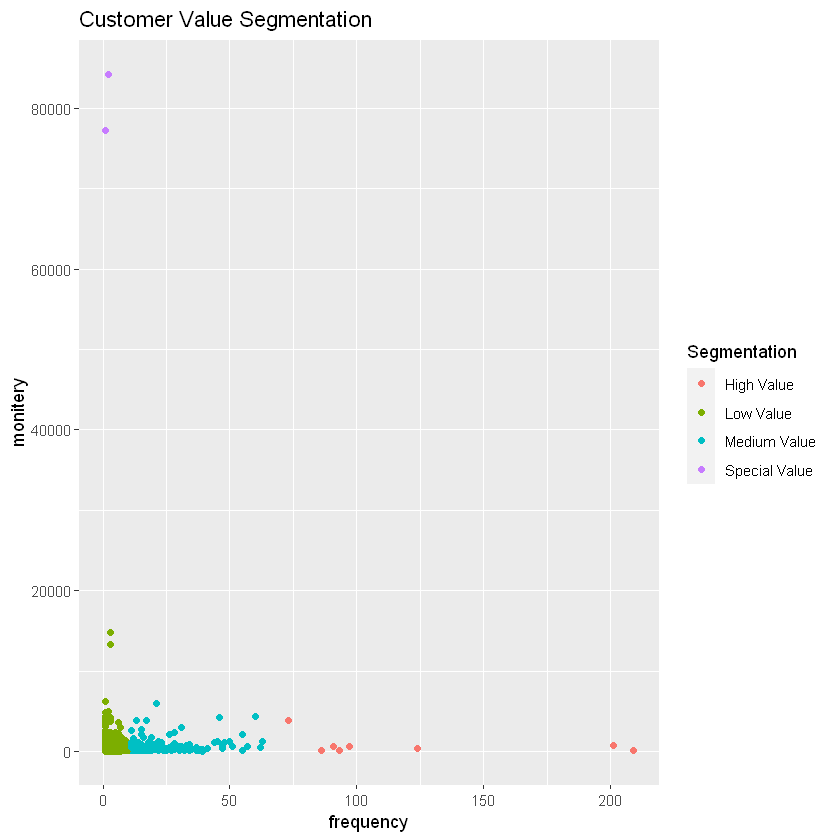

In [18]:
df_RFM <- df_RFM%>%
  mutate(segmentation = case_when(cluster == 1 ~ "Low Value",
                                  cluster == 2 ~ "Medium Value",
                                  cluster == 3 ~ "Special Value",
                                  cluster == 4 ~ "High Value",
                                  TRUE ~ "Other"))

ggplot(df_RFM, aes(frequency, monitery, color=factor(segmentation))) +
  geom_point() +
  labs(title = "Customer Value Segmentation",
       color = "Segmentation") 


### Compile all assets to Identitas.Cluster

In [19]:
Segmen.Pelanggan <- data.frame(cluster=c(1,2,3,4), 
                               Value.Segment=c("Low Value", "Medium Value",
                                             "Specia; Value", "High Value"))

Identitas.Cluster <- list(Segmentasi=segmentasi, 
                          Segmen.Pelanggan=Segmen.Pelanggan, 
                          column=c("frequency_standard", "monitery_standard"))
saveRDS(Identitas.Cluster,"cluster_rfm.rds")
glimpse(Identitas.Cluster)

List of 3
 $ Segmentasi      :List of 9
  ..$ cluster     : int [1:4338] 3 1 1 1 1 1 1 1 1 1 ...
  ..$ centers     : num [1:4, 1:2] -0.1841 1.8694 -0.3601 15.2608 -0.0279 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..$ totss       : num 8674
  ..$ withinss    : num [1:4] 613.47 564.79 7.71 339.8
  ..$ tot.withinss: num 1526
  ..$ betweenss   : num 7148
  ..$ size        : int [1:4] 3999 329 2 8
  ..$ iter        : int 4
  ..$ ifault      : int 0
  ..- attr(*, "class")= chr "kmeans"
 $ Segmen.Pelanggan:'data.frame':	4 obs. of  2 variables:
  ..$ cluster      : num [1:4] 1 2 3 4
  ..$ Value.Segment: chr [1:4] "Low Value" "Medium Value" "Specia; Value" "High Value"
 $ column          : chr [1:2] "frequency_standard" "monitery_standard"


### Total customer per segment

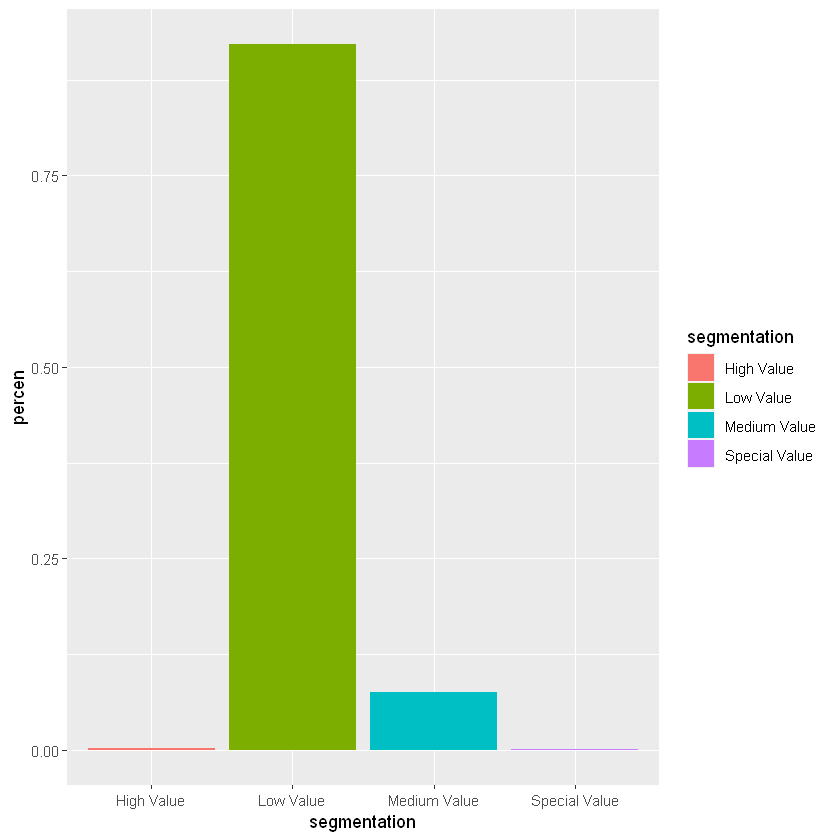

In [20]:
customer_segment <-df_RFM %>% 
  group_by(segmentation) %>% 
  summarise(freq=n_distinct(CustomerID))

customer_segment <- customer_segment %>%
  group_by(segmentation) %>%
  mutate(percen = freq/sum(customer_segment$freq))

customer_segment %>%
  ggplot(aes(segmentation, percen, fill=segmentation)) +
  geom_bar(stat = "identity")

### Total monatory per recency

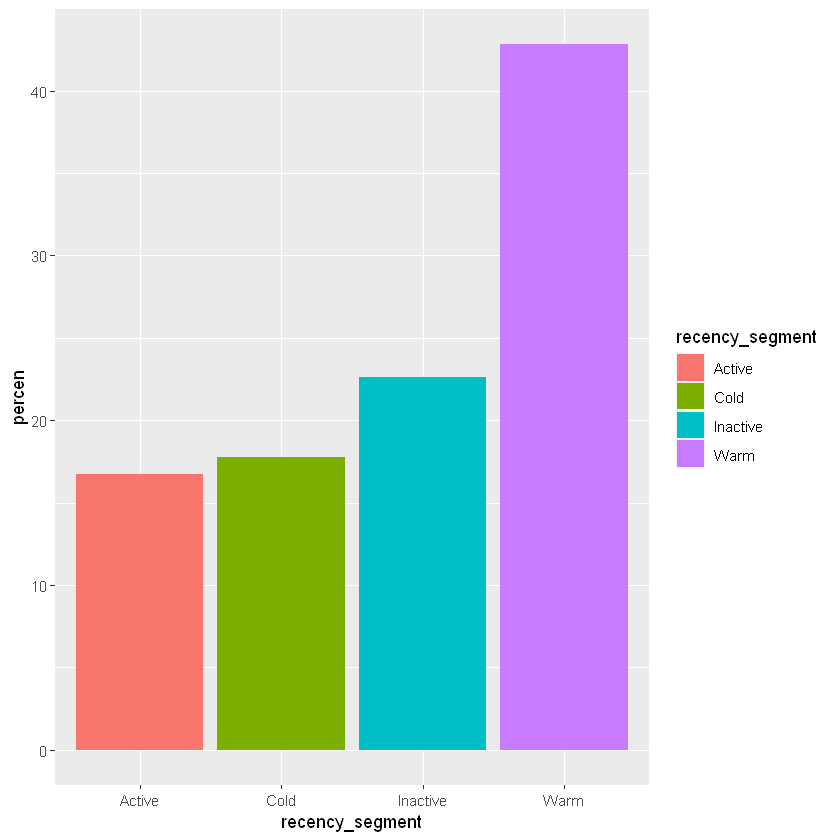

In [21]:
df_RFM <- df_RFM%>%
  mutate(recency_segment = case_when(recency <= 30 ~ "Active",
                                  recency <= 90 ~ "Warm",
                                  recency <= 180 ~ "Cold",
                                  recency >= 180 ~ "Inactive",
                                  TRUE ~ "Other"))

df_RFM %>%
  group_by(recency_segment) %>%
  summarise(monatory_segment = sum(monitery)) %>%
  mutate(percen = monatory_segment/sum(monatory_segment) *100) %>%
  ggplot(aes(recency_segment, percen, fill=recency_segment)) +
  geom_bar(stat = "identity")

### Total monatory per segment

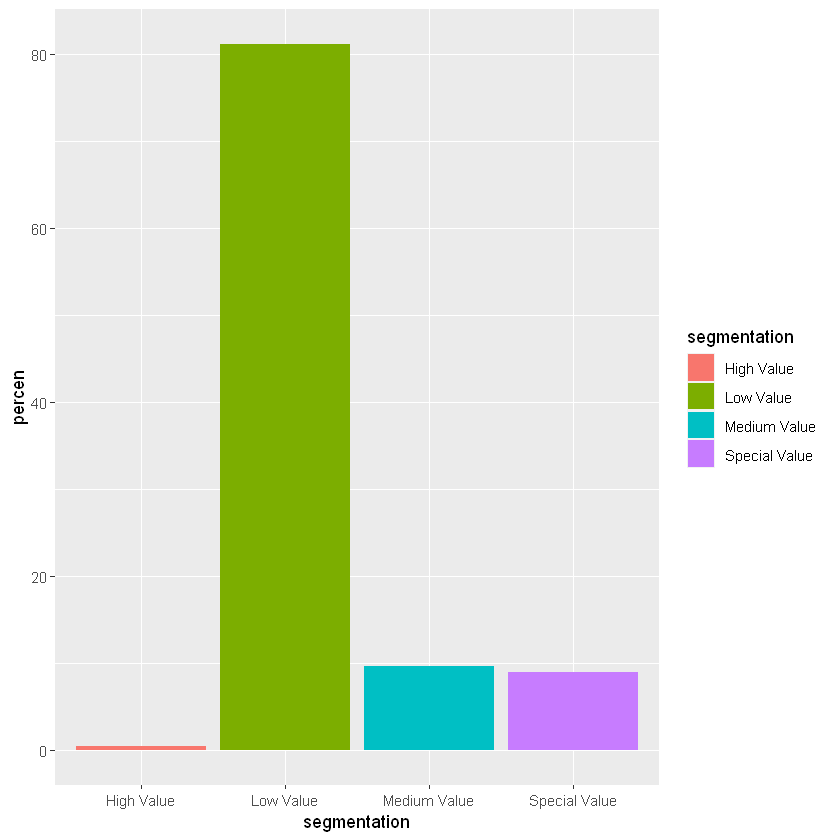

In [22]:
df_RFM %>%
  group_by(segmentation) %>%
  summarise(monatory_segment = sum(monitery)) %>%
  mutate(percen = monatory_segment/sum(monatory_segment) *100) %>%
  ggplot(aes(segmentation, percen, fill=segmentation)) +
  geom_bar(stat = "identity")

### cross value recency segment & cust segmentation

In [23]:
table(df_RFM$recency_segment, df_RFM$segmentation)

final_data <- inner_join(df_data, df_RFM, by="CustomerID")

sum_customer <- length(unique(final_data$CustomerID))
sum_monetery <- sum(final_data$total_dolar)

          
           High Value Low Value Medium Value Special Value
  Active            8       370          157             1
  Cold              0       787            9             0
  Inactive          0       985            3             1
  Warm              0      1857          160             0

The cross-value above helps the company to provide exact marketing strategy for particular customers to increase the sales

## Behavioral analysis

### Weekly Order Habit

Weekly order habit analysis toward high value & active cust

Warning message:
"Removed 1 rows containing missing values (position_stack)."


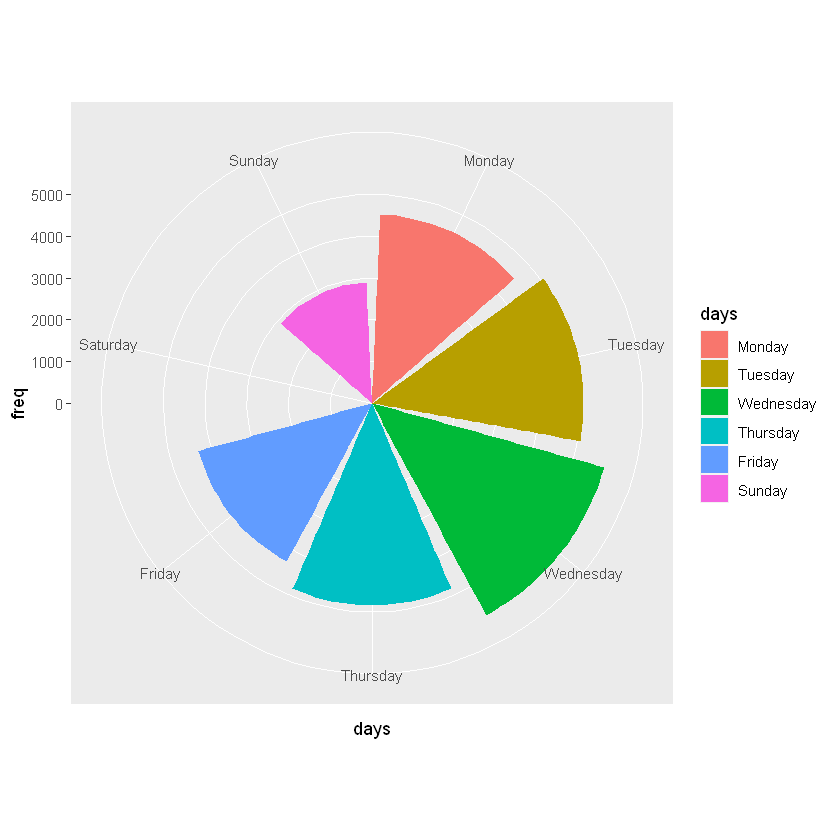

In [24]:
final_data$month <- months(final_data$InvoiceDate)

high_active_cust <- final_data %>%
  filter(segmentation == "High Value",
         recency_segment == "Active") 

days <-
  plyr::count(high_active_cust$days)
colnames(days) <- c("days", "freq")

days_cus <- data.frame(
  days = factor(c("Monday", "Tuesday", "Wednesday",
                  "Thursday", "Friday", "Saturday", "Sunday"),
                levels = c("Monday", "Tuesday", "Wednesday",
                           "Thursday", "Friday", "Saturday", "Sunday")))


data_df <- left_join(days_cus, days, by="days")
ggplot(data_df, aes(days, freq, fill=days)) +
  geom_bar(stat = "identity") +
  coord_polar()

### Monthly Order Habit

In [25]:
input_recency <- c("Active", "Warm", "Cold")
input_value <- c("Low Value", "Medium Value")

summary_customer <- final_data %>%
  filter(recency_segment %in% input_recency,
         segmentation %in% input_value)

date_day <-
  plyr::count(summary_customer$mday)
colnames(date_day) <- c("date", "freq")
date_day

date freq 
1   1   11064
2   2   10205
3   3    9266
4   4   13266
5   5   14269
6   6   16187
7   7   13315
8   8   13694
9   9   11293
10 10   11774
11 11   11338
12 12    8879
13 13   12441
14 14   12444
15 15    9810
16 16   10798
17 17   13000
18 18   11264
19 19    9157
20 20   12833
21 21   10968
22 22   11295
23 23   11799
24 24   10580
25 25   10739
26 26    7408
27 27   10964
28 28   11453
29 29    7112
30 30    9181
31 31    5706

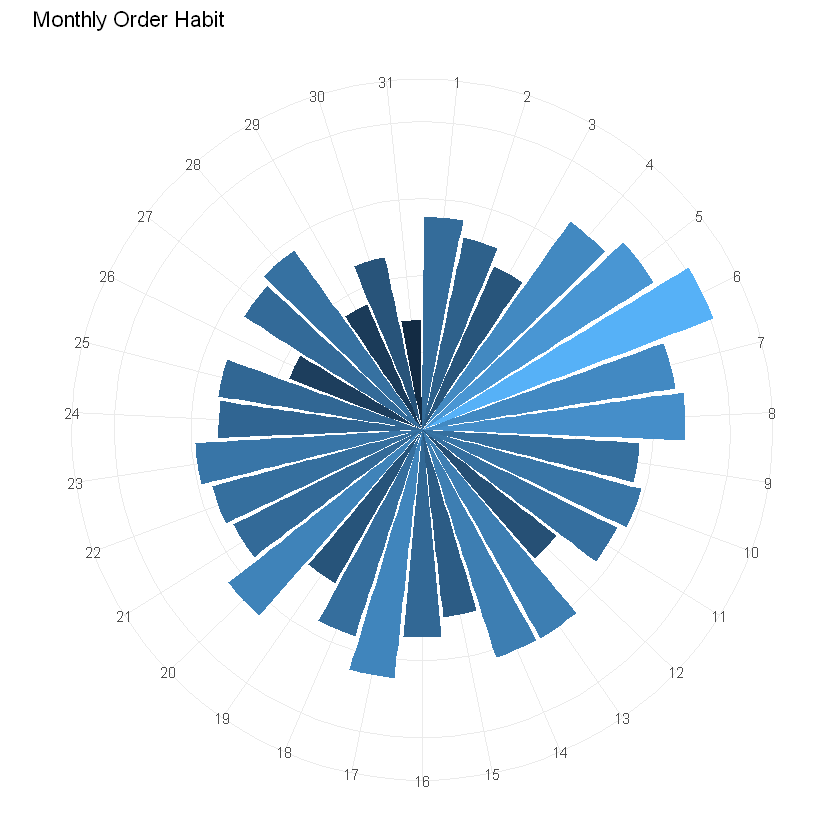

In [26]:
date_cus <- data.frame(
  date = c(1:31))

date_order_individu <- left_join(date_cus, date_day, by="date")
ggplot(date_order_individu, aes(factor(date), freq, fill=freq)) +
  geom_bar(stat = "identity") +
  coord_polar() +
  theme_minimal() +
  labs(title = "Monthly Order Habit") +
  theme(
    legend.position = "none",
    axis.title = element_blank(),
    axis.text.y = element_blank(),
    panel.grid.minor = element_blank()
  )

### Annual Order Habit

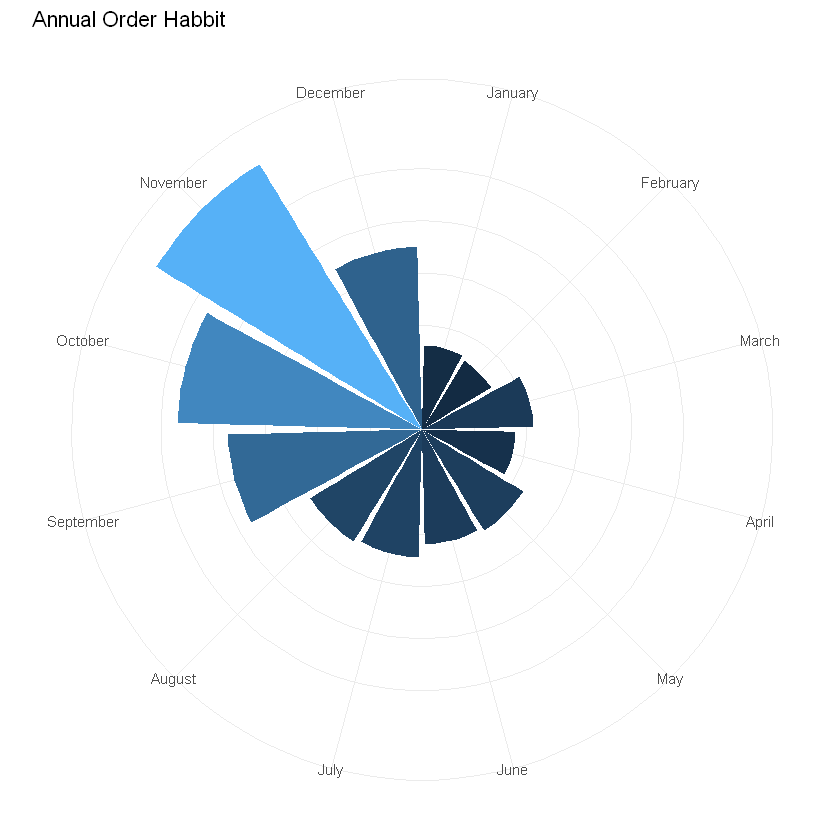

In [27]:
date_month <- plyr::count(summary_customer$month)
colnames(date_month) <- c("month", "freq")

month_year <- data.frame(
  month = factor(c(unique(final_data$month)),
                 levels = c("January", "February", "March", "April",    
                            "May", "June", "July", "August", "September",
                            "October", "November", "December"))
)


monthly_order_individu <- left_join(month_year, date_month, by="month")
monthly_order_individu$month <- factor(monthly_order_individu$month,
                                       levels = c("January", "February", "March", "April",    
                                                  "May", "June", "July", "August", "September",
                                                  "October", "November", "December"))
ggplot(monthly_order_individu, aes(month, freq, fill=freq)) +
  geom_bar(stat = "identity") +
  coord_polar() +
  theme_minimal() +
  labs(title = "Annual Order Habbit") +
  theme(
    legend.position = "none",
    axis.title = element_blank(),
    axis.text.y = element_blank(),
    panel.grid.minor = element_blank()
  )

The polar plot above helps to determina which day/date/month to hold company events that attract customers (e.g. flash sale, Year-End sale) on prime time 